### 1. Imports

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Load and explore the data

In [99]:
X_train = pd.read_csv('train.csv', index_col='PassengerId')
X_test = pd.read_csv('test.csv', index_col='PassengerId')

In [100]:
X_train.sample(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S
649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S


In [101]:
X_test.sample(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
961,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60.0,1,4,19950,263.0000,C23 C25 C27,S
1298,2,"Ware, Mr. William Jeffery",male,23.0,1,0,28666,10.5000,NaN,S
1043,3,"Matinoff, Mr. Nicola",male,NaN,0,0,349255,7.8958,NaN,C


In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [103]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


### 3. Feature Analysis

#### Numeric values

* PassengerId (Discrete)

PassengerId is the unique id of the row and it doesn't have any effect on target

* Age (Continious)

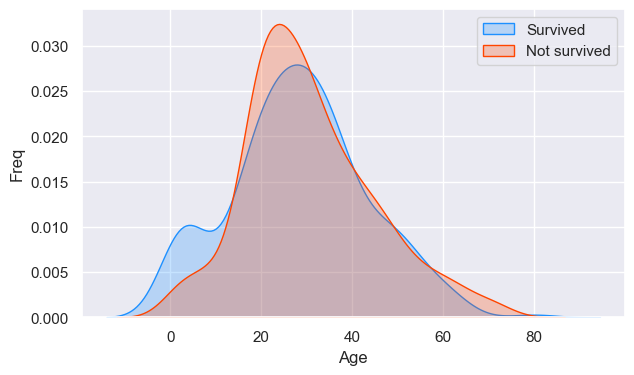

In [104]:
# set size for graph window
sns.set(rc={'figure.figsize':(7, 4)})

# explore age distribution
s = sns.kdeplot(X_train['Age'][X_train['Survived'] == 1], fill=True, color='dodgerblue')
s = sns.kdeplot(X_train['Age'][X_train['Survived'] == 0], fill=True, color='orangered')
s.set_ylabel('Freq')
s.set_xlabel('Age')
s.legend(['Survived', 'Not survived']);

It can be noted that the age distribution in the surviving and non-surviving subpopulations is not the same. Indeed, there is a peak corresponding to the young passengers who survived.

We also see that passengers between 60-80 years have less survived.

* Fare (Continious)

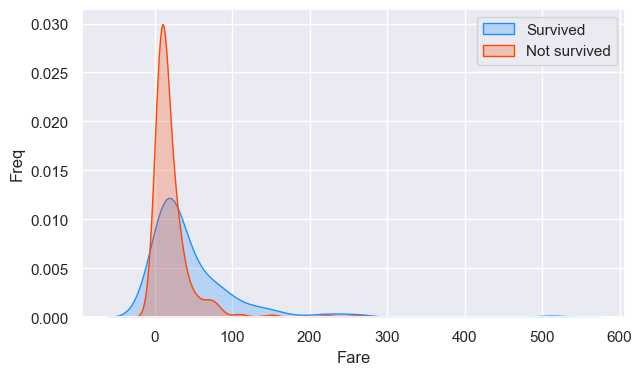

In [105]:
# explore Fare distribution
s = sns.kdeplot(X_train['Fare'][X_train['Survived'] == 1], fill=True, color='dodgerblue')
s = sns.kdeplot(X_train['Fare'][X_train['Survived'] == 0], fill=True, color='orangered')
s.set_ylabel('Freq')
s.set_xlabel('Fare')
s.legend(['Survived', 'Not survived']);

As seen above, Fare feature is positively skewed and survival rate is extremely high on the right end.

* SibSp (Discrete)

SibSp means the total number of the passengers siblings and spouse.

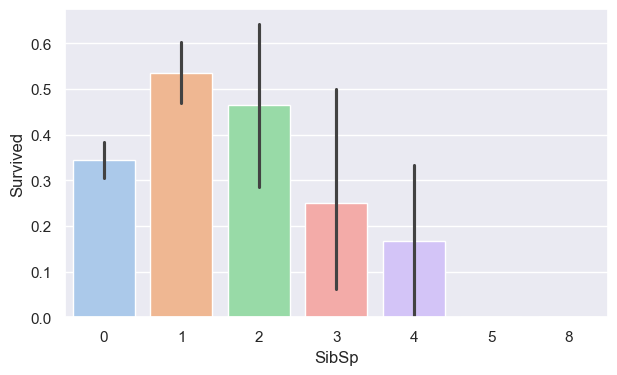

In [106]:
# explore SibSp sirvival distribution
sns.barplot(data=X_train, x='SibSp', y='Survived', palette='pastel');

The graph shows that passengers with more siblings or spouses on board had less chance of survival. It can also be noted that passengers who did not have siblings or spouses were less likely to survive than those who had one or two.

* Parch (Discrete)

Parch means the total number of the passengers' parents and children.

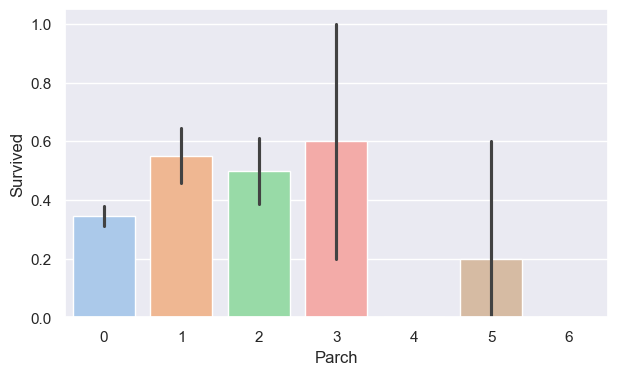

In [107]:
# explore Parch sirvival distribution
sns.barplot(data=X_train, x='Parch', y='Survived', palette='pastel');

Passengers who had fewer than four parents or children on board were more likely to survive than those passengers who had four or more. Again, people traveling alone are less likely to survive than those with 1-3 parents or children.

#### Categorical values

* Survived

Survived is the target variable we are trying to predict (0 = not survived or 1 = survived)

* Pclass

Pclass means the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1 = upper class, 2 = middle class or 3 = lower class).

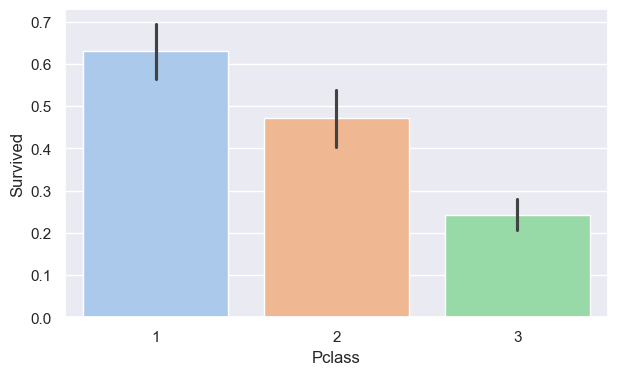

In [108]:
# explore Pclass sirvival distribution
sns.barplot(data=X_train, x='Pclass', y='Survived', palette='pastel');

People with higher socioeconomic class had a higher rate of survival.

* Name

In [109]:
X_test['Name'].sample(3)

PassengerId
1187           Angheloff, Mr. Minko
1055             Pearce, Mr. Ernest
956     Ryerson, Master. John Borie
Name: Name, dtype: object

The Name feature in addition to the name of passenger itself contains the passenger's title, which can be used further in a feature engineering.

* Sex

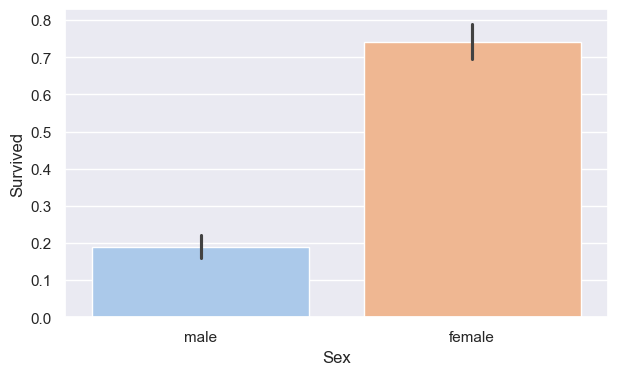

In [110]:
# explore Sex sirvival distribution
sns.barplot(data=X_train, x='Sex', y='Survived', palette='pastel');

It's obviously that Male have less chance to survive than Female.

* Ticket

In general, most likely Ticket feature (its prefix and number) does not carry any useful information

In [111]:
X_train.drop(['Ticket'], axis='columns', inplace=True)
X_test.drop(['Ticket'], axis='columns', inplace=True)

* Cabin

Due to the lack of a large number of values, Cabin feature does not carry useful information. However, the absence or presence of values in the set may make sense, which we will use further

* Embarked

Embarked means port of departure (C = Cherbourg, Q = Queenstown, S = Southampton)

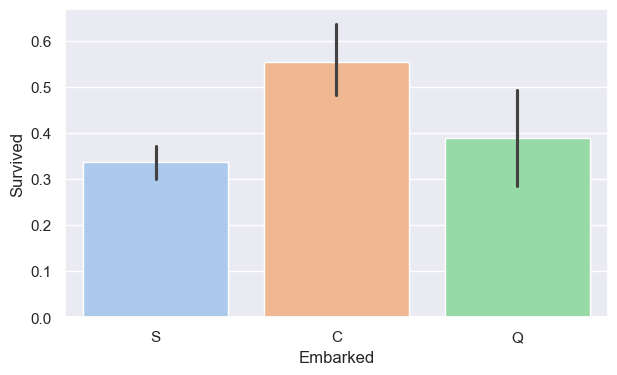

In [112]:
# explore Embarked sirvival distribution
sns.barplot(data=X_train, x='Embarked', y='Survived', palette='pastel');

It can be seen that the passengers who embarked from Cherbourg(C) have a higher survival rate

### 4. Working with missing data

In [113]:
missed_X_train = X_train.isnull().sum()
missed_X_test = X_test.isnull().sum()

print("% of missing values in the train data: ")
print(missed_X_train[missed_X_train > 0] / len(X_train.index) * 100)
print("% of missing values in the test data: ")
print(missed_X_test[missed_X_test > 0] / len(X_test.index) * 100)

% of missing values in the train data: 
Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64
% of missing values in the test data: 
Age      20.574163
Fare      0.239234
Cabin    78.229665
dtype: float64


* Age

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

Let's look at the correlation of the Age feature with some others features in all data

In [114]:
# join train and test data
X_all = pd.concat([X_train, X_test], axis='index')

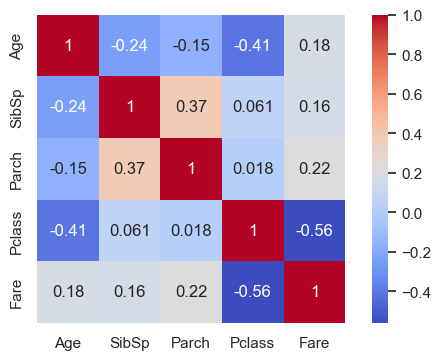

In [115]:
sns.heatmap(X_all[['Age', 'SibSp', 'Parch', 'Pclass', 'Fare']].corr(), annot=True, square=True, cmap='coolwarm');

Missing values in Age can be filled with median age, but using median age of the whole data set is not a good choice. Median age of Pclass groups is the best choice because of its high correlation with Age (-0.41). In order to be more accurate, Sex feature is used as the second level of groupby while filling the missing Age values.

In [116]:
X_all['Age'] = X_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median())).reset_index().set_index('PassengerId')['Age']

* Cabin

We will introduce a new feature CabinIsRec(categorical value), which means the presence of Cabin feature value in the data(1 = is present, 0 = not present) and drop Cabin column.

The idea is that recording the value of passenger's cabin means that he has higher socio-economical status and he has a better chance of survival.

In [117]:
X_all['CabinIsRec'] = X_all['Cabin'].notnull().astype('int')
X_all['CabinIsRec'] = X_all['Cabin'].notnull().astype('int')

X_all.drop(['Cabin'], axis='columns', inplace=True)

* Embarked

Just fill Embarked feature with the most popular value.

In [118]:
X_all['Embarked'].fillna(X_all['Embarked'].value_counts().idxmax(), inplace=True)

* Fare

Just fill Fare feature with the median value of Pclass group.

In [119]:
X_all['Fare'] = X_all.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median())).reset_index().set_index('PassengerId')['Fare']

### 5. Feature Engineering

#### One-hot encoding

The next categorical features will be converted to one-hot encoding features:
* Pclass
* Sex
* Embarked
* CabinIsRec

New categorical features which will be converted to one-hot encoding features:

* Title (from Name)

Title feature is created by extracting prefix before the Name of passenger.

In [120]:
# name prefix extraction
X_all['Title'] = X_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

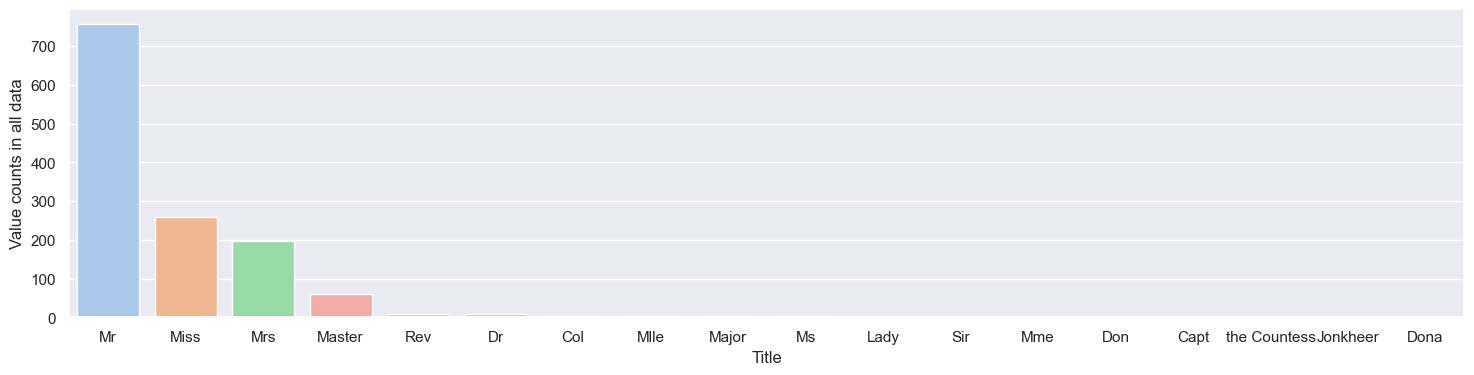

In [121]:
# set size for graph window
sns.set(rc={'figure.figsize':(18, 4)})

# explore Title distribution in train and test data
s = sns.barplot(x=X_all['Title'].value_counts().index,
                y=X_all['Title'].value_counts().values, palette='pastel');
s.set_ylabel('Value counts in all data');

According to graph above, there are many titles that are occuring very few times. Some of those titles doesn't seem correct and they need to be replaced.

In [122]:
# group and replace incorrect values in Title
X_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms', inplace=True)
X_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy', inplace=True)

# remove Name featurey
X_all.drop(['Name'], axis='columns', inplace=True)

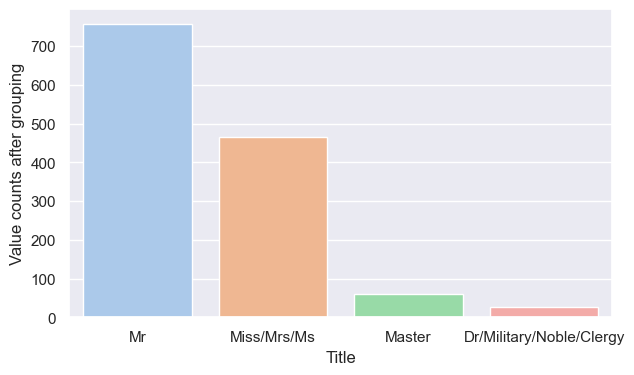

In [123]:
# set size for graph window
sns.set(rc={'figure.figsize':(7, 4)})

# explore Title distribution after grouping
s = sns.barplot(x=X_all['Title'].value_counts().index,
                y=X_all['Title'].value_counts().values, palette='pastel');
s.set_ylabel('Value counts after grouping');

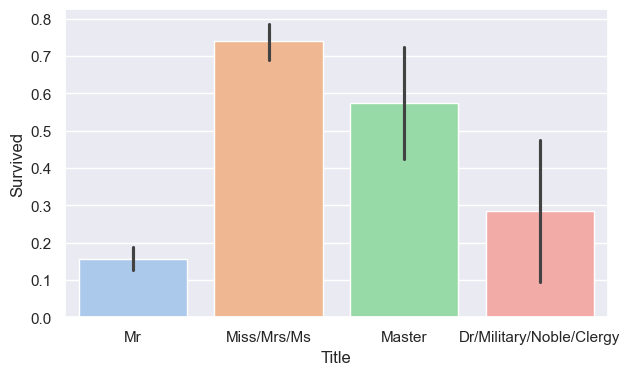

In [124]:
# explore Title survived distribution
sns.barplot(data=X_all[X_all['Survived'].notnull()], x='Title', y='Survived', palette='pastel');

* FamilySize (from SibSp and Parch)

FamilySize feature is created by adding SibSp, Parch and 1. Those columns are added in order to find the total size of families. Adding 1 at the end, is the current passenger.

In [125]:
X_all['FamilySize'] = X_all['SibSp'] + X_all['Parch'] + 1

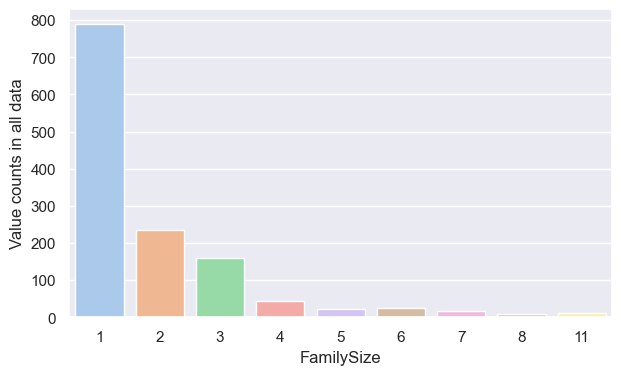

In [126]:
# explore FamilySize distribution in train and test data
s = sns.barplot(x=X_all['FamilySize'].value_counts().index,
                y=X_all['FamilySize'].value_counts().values, palette='pastel');
s.set_ylabel('Value counts in all data');

We will group the FamilySize feature into 4 groups (1 = Alone; 2, 3, 4 = Small; 5, 6 = Medium; 7, 8, 11 = Large)

In [127]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 
              5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}

# remove SibSp and Parch feature and add FamilySize feature
X_all['FamilySize'] = X_all['FamilySize'].map(family_map)
X_all.drop(['SibSp', 'Parch'], axis='columns', inplace=True)

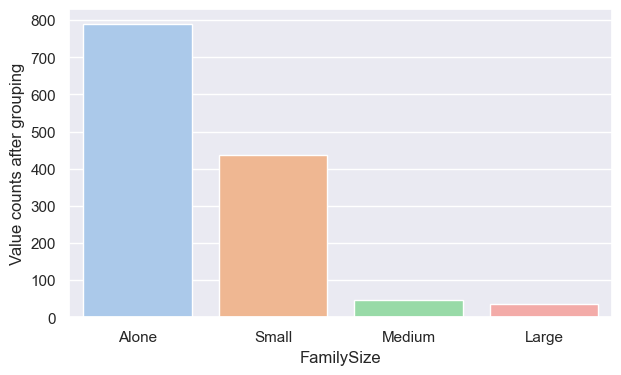

In [128]:
# explore FamilySize distribution after grouping
s = sns.barplot(x=X_all['FamilySize'].value_counts().index,
                y=X_all['FamilySize'].value_counts().values, palette='pastel');
s.set_ylabel('Value counts after grouping');

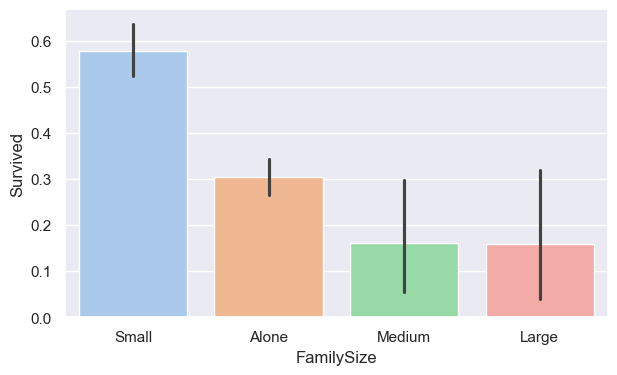

In [129]:
# explore Title survived distribution
sns.barplot(data=X_all[X_all['Survived'].notnull()], x='FamilySize', y='Survived', palette='pastel');

Small family size(2-4 people) are more likely to survive than any other age group.

In [130]:
from sklearn.preprocessing import OneHotEncoder

def feature_combiner(feature, category):
    return str(feature) + "_" + str(category)

oh_encoder = OneHotEncoder(feature_name_combiner=feature_combiner, sparse_output=False)
features_to_oh_encode = ['Pclass', 'Sex', 'Embarked', 'CabinIsRec', 'Title', 'FamilySize']

# fit and apply one-hot encoder to each column with categorical data
oh_encoder.fit(X_all[features_to_oh_encode])
oh_cols = pd.DataFrame(oh_encoder.transform(X_all[features_to_oh_encode]))
oh_cols.columns = oh_encoder.get_feature_names_out()
oh_cols.index = X_all.index

# add one-hot encoded columns to features
X_all = pd.concat([X_all, oh_cols], axis='columns')

# remove categorical columns
X_all.drop(features_to_oh_encode, axis='columns', inplace=True)

### Ordinal Encoding

New categorical features which will be converted to ordinal encoding features:

* AgeGroup (from Age)

In [131]:
# convert ages to groups of age ranges
age_groups = [0, 5, 12, 18, 24, 35, 55, np.inf]
age_labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']

# remove Name feature and add AgeGroup feature
X_all['AgeGroup'] = pd.cut(X_all['Age'], age_groups, labels = age_labels)

X_all.drop(['Age'], axis='columns', inplace=True)

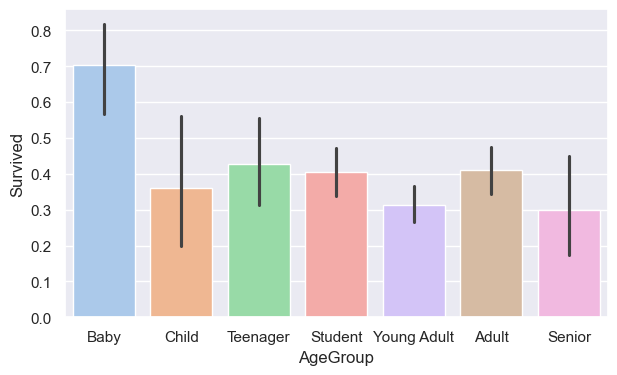

In [132]:
# explore AgeGroup survival distribution
sns.barplot(data=X_all[X_all['Survived'].notnull()], x='AgeGroup', y='Survived', palette='pastel');

Childs are more likely to survive than any other age group.

* FareGroup (from Fare)

In [133]:
# divide fares to fare groups
X_all['FareGroup'] = pd.qcut(X_all['Fare'], 13)

# remove Fare feature
X_all.drop(['Fare'], axis='columns', inplace=True)

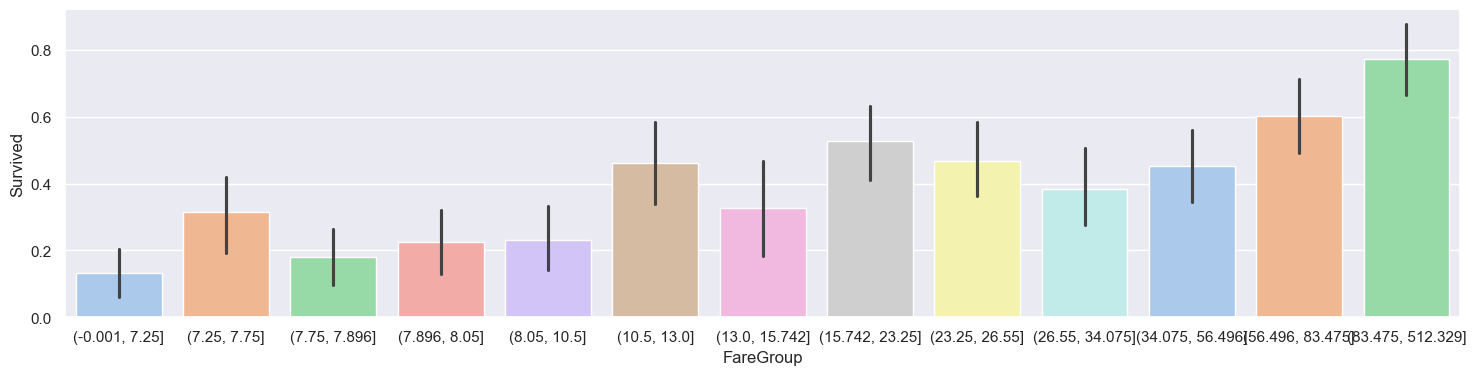

In [134]:
# set size for graph window
sns.set(rc={'figure.figsize':(18, 4)})

# explore FareGroup survival distribution
sns.barplot(data=X_all[X_all['Survived'].notnull()], x='FareGroup', y='Survived', palette='pastel');

As seen that the more a passenger has paid for a ticket, the more chances he has to survive, which correlates with his socio-economic status.

In [135]:
from sklearn.preprocessing import OrdinalEncoder

ord_encoder = OrdinalEncoder()
features_to_ord_encode = ['AgeGroup', 'FareGroup']

# fit and apply ordinal encoder to each column with categorical data
X_all[features_to_ord_encode] = ord_encoder.fit_transform(X_all[features_to_ord_encode])

### 6. Modeling

#### Cleaning the data

In [136]:
# export from X_all train data and remove Survived labels
X_train = X_all[X_all['Survived'].notnull()]
y_train = X_train['Survived']
X_train.drop(['Survived'], axis='columns', inplace=True)

# export from X_all test data
X_test = X_all[X_all['Survived'].isnull()]
X_test.drop(['Survived'], axis='columns', inplace=True)

Let's see what our final training and testing data looks like

In [137]:
X_train.sample(3)

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,CabinIsRec_0,CabinIsRec_1,Title_Dr/Military/Noble/Clergy,Title_Master,Title_Miss/Mrs/Ms,Title_Mr,FamilySize_Alone,FamilySize_Large,FamilySize_Medium,FamilySize_Small,AgeGroup,FareGroup
PassengerId,,,,,,,,,,,,,,,,,,,,
233,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,6.0
171,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,9.0
195,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0


In [138]:
X_test.sample(3)

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,CabinIsRec_0,CabinIsRec_1,Title_Dr/Military/Noble/Clergy,Title_Master,Title_Miss/Mrs/Ms,Title_Mr,FamilySize_Alone,FamilySize_Large,FamilySize_Medium,FamilySize_Small,AgeGroup,FareGroup
PassengerId,,,,,,,,,,,,,,,,,,,,
1030,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,3.0
907,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,9.0
1048,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,12.0


#### Choosing a model

In [139]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score 

RND_STATE = 7
models = {
    'XGBClassifier': XGBClassifier(random_state = RND_STATE),
    'AdaClassifier': AdaBoostClassifier(
        DecisionTreeClassifier(random_state=RND_STATE), 
        random_state=RND_STATE, learning_rate=0.1
        ),
    'RFClassifier': RandomForestClassifier(random_state = RND_STATE),
    'DTClassifier': DecisionTreeClassifier(random_state = RND_STATE),
    'KNClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(random_state = RND_STATE),
    'SVC': SVC(random_state = RND_STATE),
    'MLPClassifier': MLPClassifier(random_state=RND_STATE)
}

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

cv_results = {model: np.array([cross_val_score(models[model], X_train, y_train, cv=kfold, n_jobs=8, scoring='accuracy')]) 
              for model in models}

cv_means = {model: cv_results[model].mean()
              for model in models}

cv_stds = {model: cv_results[model].std()
              for model in models}

In [140]:
print("The best model is {model} with accuracy score:{acc: .4f} +-{std: .4f}".format(
    model=max(cv_means, key=cv_means.get),
    acc=max(cv_means.values()),
    std=cv_stds[max(cv_means, key=cv_means.get)]
))

The best model is LogisticRegression with accuracy score: 0.8305 +- 0.0370


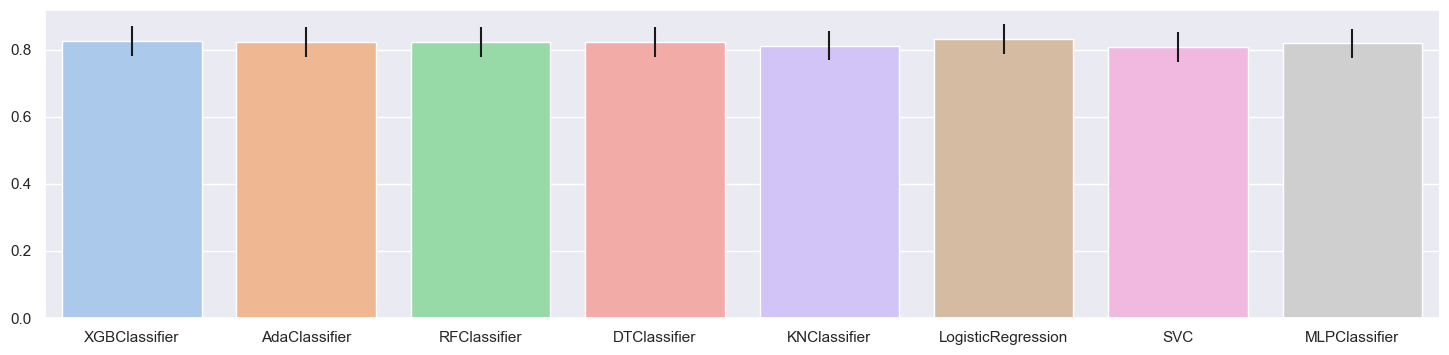

In [141]:
# explore models accuracy distribution
sns.barplot(x=list(cv_means.keys()), y=list(cv_means.values()),
                palette='pastel', **{'yerr': max(cv_stds.values())});

#### Hyperparameter tuning for XGBoost, AdaBoost, RF, SVC

In [142]:
# XGBoost grid search
xgbClassifier = XGBClassifier()

xgbClassifierParamGrid = {
                          'gamma': [0.5, 1, 1.5, 2, 5],
                          'subsample': [0.6, 0.8, 1.0],
                          'colsample_bytree': [0.6, 0.8, 1.0],
                          'max_depth': [3, 4, 5],
                          'min_child_weight': [1, 5, 10]
                          }

gsXgbClassifier = GridSearchCV(xgbClassifier, param_grid=xgbClassifierParamGrid, cv=kfold,
                               scoring="accuracy", n_jobs=8, verbose=1)

gsXgbClassifier.fit(X_train, y_train)

bestXgbClassifier = gsXgbClassifier.best_estimator_

print("Best score: {score}".format(score=gsXgbClassifier.best_score_))

Fitting 10 folds for each of 405 candidates, totalling 4050 fits


Best score: 0.8417602996254683


In [143]:
# AdaBoost grid search
adaClassifier = AdaBoostClassifier(
    DecisionTreeClassifier(), random_state=RND_STATE)

adaParamGrid = {"base_estimator__criterion": ["gini", "entropy"],
                "base_estimator__splitter":   ["best", "random"],
                "algorithm": ["SAMME", "SAMME.R"],
                "n_estimators": [2, 5, 10, 100, 200],
                "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsAdaClassifier = GridSearchCV(
    adaClassifier, param_grid=adaParamGrid, cv=kfold, scoring="accuracy", n_jobs=8, verbose=1)

gsAdaClassifier.fit(X_train, y_train)

bestAdaClassifier = gsAdaClassifier.best_estimator_

print("Best score: {score}".format(score=gsAdaClassifier.best_score_))

Fitting 10 folds for each of 280 candidates, totalling 2800 fits


Best score: 0.8372534332084894


In [144]:
# Random Forest grid search
rfClassifier = RandomForestClassifier()

rfParamGrid = {"max_depth": [2, 4, 6],
               "max_features": [1, 3, 10],
               "min_samples_split": [2, 3, 10],
               "min_samples_leaf": [1, 3, 10],
               "bootstrap": [True, False],
               "n_estimators": [100, 200, 300],
               "criterion": ["gini"]}

gsRfClassifier = GridSearchCV(
    rfClassifier, param_grid=rfParamGrid, cv=kfold, scoring="accuracy", n_jobs=8, verbose=1)

gsRfClassifier.fit(X_train, y_train)

bestRfClassifier = gsRfClassifier.best_estimator_

print("Best score: {score}".format(score=gsRfClassifier.best_score_))

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


Best score: 0.8395006242197253


In [145]:
# SVC grid search
svc = SVC(probability=True)

svcParamGrid = {'kernel': ['rbf'],
                'gamma': [0.001, 0.01, 0.1, 1],
                'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVC = GridSearchCV(svc, param_grid=svcParamGrid, cv=kfold,
                     scoring="accuracy", n_jobs=8, verbose=1)

gsSVC.fit(X_train, y_train)

bestSVC = gsSVC.best_estimator_

print("Best score: {score}".format(score=gsSVC.best_score_))

Fitting 10 folds for each of 28 candidates, totalling 280 fits


Best score: 0.832796504369538


#### Voting Classifier from XGB, Ada, RF, SVC classifiers

In [146]:
votingClassifier = VotingClassifier(estimators=[('xgb', bestXgbClassifier), ('ada', bestAdaClassifier), 
                                                ('rf', bestRfClassifier), ('svc', bestSVC)], 
                                    voting='soft', n_jobs=8)

models['XGBClassifier'] = bestXgbClassifier
models['AdaClassifier'] = bestAdaClassifier
models['RFClassifier'] = bestRfClassifier
models['SVC'] = bestSVC
models['VotingClassifier'] = votingClassifier

for model in models.values():
    model.fit(X_train, y_train)

In [147]:
cv_results = {model: np.array([cross_val_score(models[model], X_train, y_train, cv=kfold, n_jobs=8, scoring='accuracy')]) 
              for model in models}

cv_means = {model: cv_results[model].mean()
              for model in models}

cv_stds = {model: cv_results[model].std()
              for model in models}

print("The best model is {model} with accuracy score:{acc: .4f} +-{std: .4f}".format(
    model=max(cv_means, key=cv_means.get),
    acc=max(cv_means.values()),
    std=cv_stds[max(cv_means, key=cv_means.get)]
))

The best model is XGBClassifier with accuracy score: 0.8418 +- 0.0412


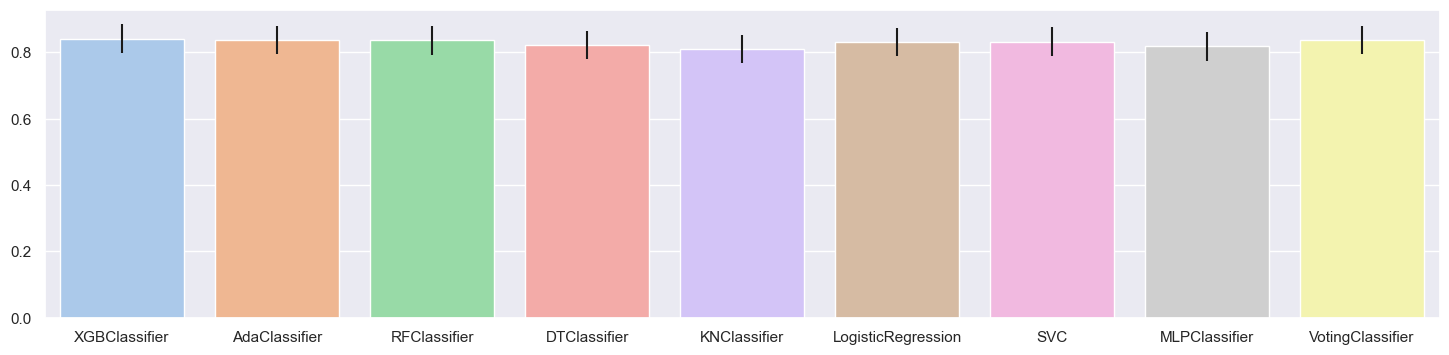

In [148]:
# explore models accuracy distribution
sns.barplot(x=list(cv_means.keys()), y=list(cv_means.values()),
                palette='pastel', **{'yerr': max(cv_stds.values())});

#### Make predictions

In [149]:
X_predict = pd.DataFrame({'Survived': models['XGBClassifier'].predict(X_test).astype(int)},
                         index = X_test.index)

X_predict.to_csv("submission_predictions.csv")